Loading data from ASL_Alpha...
Found 26 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Found 10 augmented folders for class A
Found 10 augmented folders for class B
Found 10 augmented folders for class C
Found 10 augmented folders for class D
Found 10 augmented folders for class E
Found 10 augmented folders for class F
Found 10 augmented folders for class G
Found 10 augmented folders for class H
Found 10 augmented folders for class I
Found 10 augmented folders for class J
Found 10 augmented folders for class K
Found 10 augmented folders for class L
Found 10 augmented folders for class M
Found 10 augmented folders for class N
Found 10 augmented folders for class O
Found 10 augmented folders for class P
Found 10 augmented folders for class Q
Found 10 augmented folders for class R
Found 10 augmented folders for class S
Found 10 augmented folders for class T
Found 10 augmented folders for class U
F

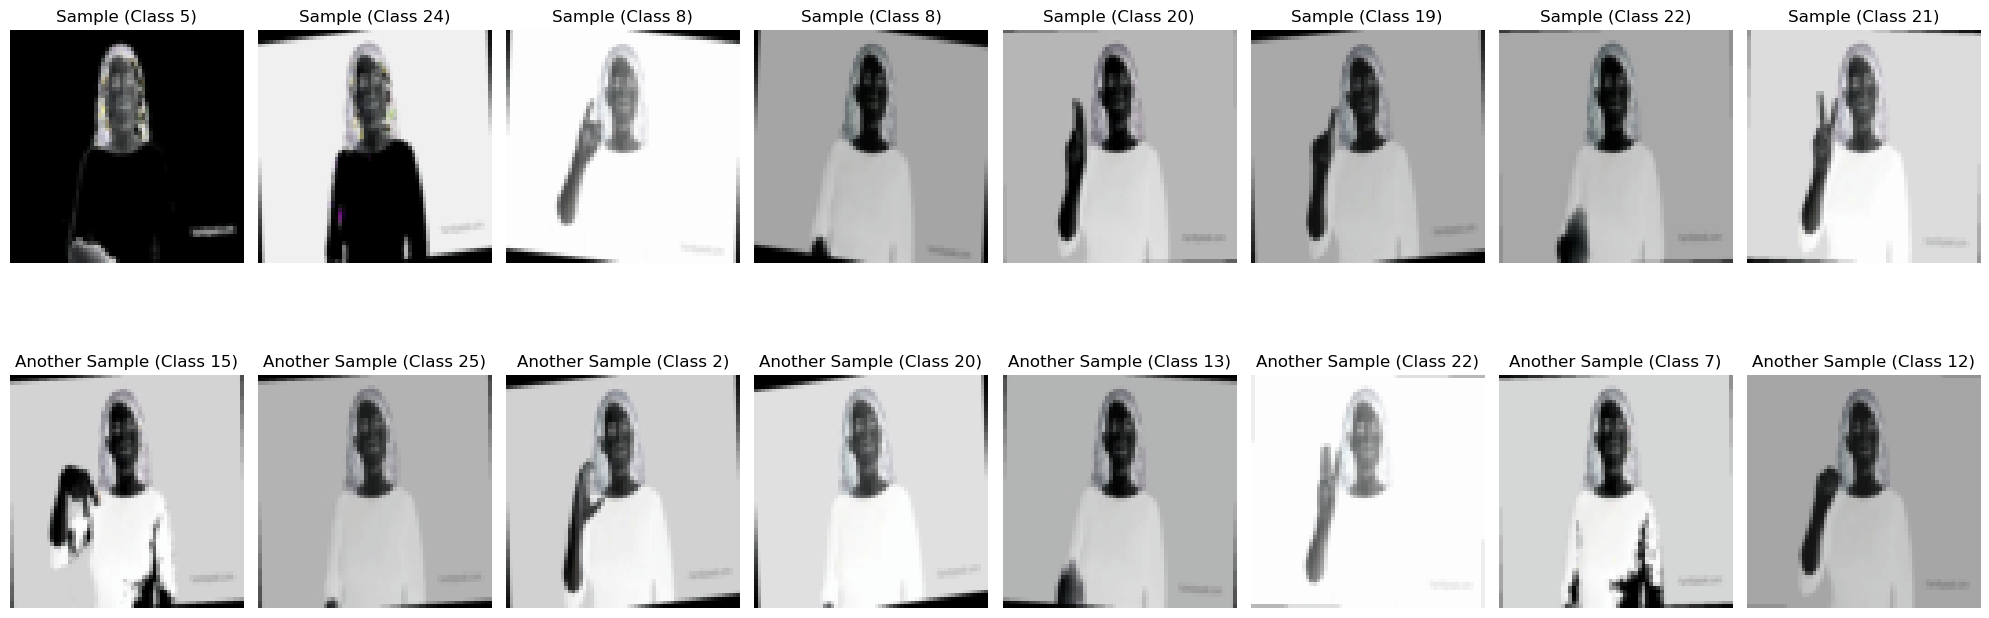

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data preprocessing class for already augmented images
class ASLDataPreprocessor:
    def __init__(self, data_dir, img_size=(64, 64), batch_size=32):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Simple transform for all data (no augmentation needed since images are pre-augmented)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def load_and_preprocess_data(self):
        """Load and preprocess all images from the dataset including augmented subfolders"""
        images = []
        labels = []
        
        print(f"Loading data from {self.data_dir}...")
        print(f"Found {len(self.classes)} classes: {self.classes}")
        
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # Check if there are augmented subfolders
            subfolders = [d for d in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, d))]
            augmented_folders = [d for d in subfolders if d.startswith('augmented_')]
            
            if augmented_folders:
                # Load from augmented subfolders
                print(f"Found {len(augmented_folders)} augmented folders for class {class_name}")
                for aug_folder in augmented_folders:
                    aug_folder_path = os.path.join(class_dir, aug_folder)
                    for img_name in os.listdir(aug_folder_path):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img_path = os.path.join(aug_folder_path, img_name)
                            try:
                                # Load image
                                image = cv2.imread(img_path)
                                if image is not None:
                                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                                    images.append(image)
                                    labels.append(class_idx)
                            except Exception as e:
                                print(f"Error loading {img_path}: {e}")
            else:
                # Load directly from class folder (no augmented subfolders)
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_dir, img_name)
                        try:
                            # Load image
                            image = cv2.imread(img_path)
                            if image is not None:
                                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                                images.append(image)
                                labels.append(class_idx)
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
        
        print(f"Loaded {len(images)} images with {len(set(labels))} classes")
        return images, labels
    
    def create_data_loaders(self, test_size=0.2, val_size=0.1):
        """Create train, validation, and test data loaders"""
        images, labels = self.load_and_preprocess_data()
        
        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            images, labels, test_size=test_size, stratify=labels, random_state=42
        )
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=42
        )
        
        print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")
        
        # Create datasets (all use the same transform since no augmentation is needed)
        train_dataset = ASLDataset(X_train, y_train, self.transform)
        val_dataset = ASLDataset(X_val, y_val, self.transform)
        test_dataset = ASLDataset(X_test, y_test, self.transform)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
        
        return train_loader, val_loader, test_loader

# Custom Dataset class
class ASLDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Visualization function
def visualize_samples(dataset, num_samples=8):
    """Visualize sample images from the dataset"""
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    for i in range(num_samples):
        # Sample image
        img, label = dataset[i]
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
            # Denormalize
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
        
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Sample (Class {label})')
        axes[0, i].axis('off')
        
        # Another sample from the same class
        if i + num_samples < len(dataset):
            img2, label2 = dataset[i + num_samples]
            if isinstance(img2, torch.Tensor):
                img2 = img2.permute(1, 2, 0).numpy()
                # Denormalize
                img2 = img2 * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img2 = np.clip(img2, 0, 1)
            
            axes[1, i].imshow(img2)
            axes[1, i].set_title(f'Another Sample (Class {label2})')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Update this path to your ASL dataset
    data_dir = "ASL_Alpha"
    
    # Create preprocessor
    preprocessor = ASLDataPreprocessor(data_dir, img_size=(64, 64), batch_size=32)
    
    # Create data loaders
    train_loader, val_loader, test_loader = preprocessor.create_data_loaders()
    
    # Visualize some samples
    if len(train_loader.dataset) > 0:
        visualize_samples(train_loader.dataset)

In [2]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, input_channels=1, num_classes=26, hidden_size=128, num_layers=2):
        super(CNN_LSTM, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # LSTM layer (after flattening)
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, 
                           num_layers=num_layers, batch_first=True, dropout=0.3)
        
        # Final classification layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Activation functions
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # CNN feature extraction
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output for LSTM
        batch_size = x.size(0)
        x = x.view(batch_size, -1, 128)  # Reshape to (batch_size, sequence_length, features)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last output from LSTM
        lstm_out = lstm_out[:, -1, :]
        
        # Apply dropout and final classification
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        
        return output 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
import os
import json
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class ASLTrainer:
    def __init__(self, model, train_loader, val_loader, device, config):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config
        
        # Initialize optimizer and loss function
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(
            self.model.parameters(), 
            lr=config['learning_rate'], 
            weight_decay=config['weight_decay']
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        
        # TensorBoard writer
        self.writer = SummaryWriter(log_dir=config['log_dir'])
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
        # Best model tracking
        self.best_val_loss = float('inf')
        self.best_val_accuracy = 0.0
        
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(self.device), target.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            # Statistics
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100. * correct / total:.2f}%'
            })
        
        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy
    
    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation')
            for data, target in pbar:
                data, target = data.to(self.device), target.to(self.device)
                
                output = self.model(data)
                loss = self.criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
                
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100. * correct / total:.2f}%'
                })
        
        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy
    
    def save_checkpoint(self, epoch, is_best=False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'best_val_loss': self.best_val_loss,
            'best_val_accuracy': self.best_val_accuracy,
            'config': self.config
        }
        
        # Save regular checkpoint
        checkpoint_path = os.path.join(self.config['checkpoint_dir'], f'checkpoint_epoch_{epoch}.pth')
        torch.save(checkpoint, checkpoint_path)
        
        # Save best model if this is the best so far
        if is_best:
            best_path = os.path.join(self.config['checkpoint_dir'], 'best_model.pth')
            torch.save(checkpoint, best_path)
            print(f"\nNew best model saved! Validation Accuracy: {self.best_val_accuracy:.2f}%")
    
    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def train(self):
        """Main training loop"""
        print(f"Starting training on {self.device}...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        start_time = time.time()
        
        for epoch in range(1, self.config['epochs'] + 1):
            print(f"\nEpoch {epoch}/{self.config['epochs']}")
            print("-" * 50)
            
            # Training phase
            train_loss, train_acc = self.train_epoch()
            
            # Validation phase
            val_loss, val_acc = self.validate_epoch()
            
            # Update learning rate
            self.scheduler.step(val_loss)
            
            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            # Log to TensorBoard
            self.writer.add_scalar('Loss/Train', train_loss, epoch)
            self.writer.add_scalar('Loss/Validation', val_loss, epoch)
            self.writer.add_scalar('Accuracy/Train', train_acc, epoch)
            self.writer.add_scalar('Accuracy/Validation', val_acc, epoch)
            self.writer.add_scalar('Learning_Rate', self.optimizer.param_groups[0]['lr'], epoch)
            
            # Print epoch summary
            print(f"\nEpoch {epoch} Summary:")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            # Check if this is the best model
            is_best = val_acc > self.best_val_accuracy
            if is_best:
                self.best_val_accuracy = val_acc
                self.best_val_loss = val_loss
            
            # Save checkpoint
            if epoch % self.config['save_frequency'] == 0 or is_best:
                self.save_checkpoint(epoch, is_best)
            
            # Early stopping check
            if len(self.val_losses) >= self.config['patience']:
                recent_losses = self.val_losses[-self.config['patience']:]
                if all(recent_losses[i] >= recent_losses[i-1] for i in range(1, len(recent_losses))):
                    print(f"\nEarly stopping triggered after {epoch} epochs")
                    break
        
        # Training completed
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time/3600:.2f} hours")
        print(f"Best validation accuracy: {self.best_val_accuracy:.2f}%")
        
        # Plot training history
        self.plot_training_history()
        
        # Close TensorBoard writer
        self.writer.close()
        
        return self.best_val_accuracy

# Training configuration
training_config = {
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'epochs': 100,
    'patience': 15,
    'save_frequency': 10,
    'checkpoint_dir': './checkpoints',
    'log_dir': './logs',
    'model_config': {
        'input_channels': 3,  # RGB images
        'num_classes': 26,    # ASL alphabet
        'hidden_size': 128,
        'num_layers': 2
    }
}

# Create directories
os.makedirs(training_config['checkpoint_dir'], exist_ok=True)
os.makedirs(training_config['log_dir'], exist_ok=True)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# Create model
model = CNN_LSTM(**training_config['model_config'])
    
# Initialize trainer
trainer = ASLTrainer(model, train_loader, val_loader, device, training_config)
    
# Start training
best_accuracy = trainer.train() 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tqdm import tqdm
import json
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class ASLTester:
    def __init__(self, model, test_loader, device, class_names):
        self.model = model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.class_names = class_names
        
    def load_best_model(self, checkpoint_path):
        """Load the best trained model"""
        print(f"Loading model from {checkpoint_path}...")
        
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"Model loaded successfully!")
        print(f"Best validation accuracy: {checkpoint['best_val_accuracy']:.2f}%")
        print(f"Training completed at epoch: {checkpoint['epoch']}")
        
        return checkpoint
    
    def test_model(self):
        """Evaluate model on test set"""
        self.model.eval()
        
        all_predictions = []
        all_targets = []
        all_probabilities = []
        
        print("Testing model on test set...")
        
        with torch.no_grad():
            for data, target in tqdm(self.test_loader, desc='Testing'):
                data, target = data.to(self.device), target.to(self.device)
                
                # Forward pass
                output = self.model(data)
                probabilities = torch.softmax(output, dim=1)
                predictions = torch.argmax(output, dim=1)
                
                # Store results
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(all_targets, all_predictions)
        
        print(f"\nTest Results:")
        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        return {
            'predictions': all_predictions,
            'targets': all_targets,
            'probabilities': all_probabilities,
            'accuracy': accuracy
        }
    
    def plot_confusion_matrix(self, predictions, targets):
        """Plot confusion matrix"""
        cm = confusion_matrix(targets, predictions)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        return cm
    
    def plot_class_accuracy(self, predictions, targets):
        """Plot per-class accuracy"""
        cm = confusion_matrix(targets, predictions)
        class_accuracy = cm.diagonal() / cm.sum(axis=1)
        
        plt.figure(figsize=(15, 6))
        bars = plt.bar(range(len(self.class_names)), class_accuracy)
        plt.xlabel('ASL Classes')
        plt.ylabel('Accuracy')
        plt.title('Per-Class Accuracy')
        plt.xticks(range(len(self.class_names)), self.class_names, rotation=45)
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        return class_accuracy
    
    def analyze_misclassifications(self, predictions, targets, probabilities, num_samples=10):
        """Analyze misclassified samples"""
        misclassified_indices = np.where(np.array(predictions) != np.array(targets))[0]
        
        if len(misclassified_indices) == 0:
            print("No misclassifications found!")
            return
        
        print(f"\nAnalyzing {min(num_samples, len(misclassified_indices))} misclassified samples:")
        
        # Sample some misclassifications
        sample_indices = np.random.choice(misclassified_indices, 
                                        min(num_samples, len(misclassified_indices)), 
                                        replace=False)
        
        for idx in sample_indices:
            true_class = self.class_names[targets[idx]]
            pred_class = self.class_names[predictions[idx]]
            confidence = probabilities[idx][predictions[idx]]
            
            print(f"Sample {idx}: True={true_class}, Predicted={pred_class}, Confidence={confidence:.3f}")
    
    def generate_classification_report(self, predictions, targets):
        """Generate detailed classification report"""
        report = classification_report(targets, predictions, 
                                      target_names=self.class_names, 
                                      output_dict=True)
        
        print("\nDetailed Classification Report:")
        print(classification_report(targets, predictions, target_names=self.class_names))
        
        return report
    
    def save_test_results(self, results, output_path='test_results.json'):
        """Save test results to file"""
        # Convert numpy arrays to lists for JSON serialization
        results_to_save = {
            'accuracy': float(results['accuracy']),
            'predictions': [int(p) for p in results['predictions']],
            'targets': [int(t) for t in results['targets']],
            'class_names': self.class_names,
            'timestamp': str(np.datetime64('now'))
        }
        
        with open(output_path, 'w') as f:
            json.dump(results_to_save, f, indent=2)
        
        print(f"\nTest results saved to {output_path}")
    
    def run_comprehensive_test(self, checkpoint_path):
        """Run comprehensive testing and analysis"""
        print("Starting comprehensive model testing...")
        print("=" * 60)
        
        # Load model
        checkpoint = self.load_best_model(checkpoint_path)
        
        # Test model
        results = self.test_model()
        
        # Generate visualizations and reports
        print("\nGenerating visualizations and reports...")
        
        # Confusion matrix
        cm = self.plot_confusion_matrix(results['predictions'], results['targets'])
        
        # Per-class accuracy
        class_acc = self.plot_class_accuracy(results['predictions'], results['targets'])
        
        # Classification report
        report = self.generate_classification_report(results['predictions'], results['targets'])
        
        # Misclassification analysis
        self.analyze_misclassifications(results['predictions'], results['targets'], 
                                       results['probabilities'])
        
        # Save results
        self.save_test_results(results)
        
        print("\n" + "=" * 60)
        print("Comprehensive testing completed!")
        
        return results, cm, class_acc, report

# Initialize tester
tester = ASLTester(model, test_loader, device, class_names=preprocessor.classes)
    
# Run comprehensive testing
checkpoint_path = './checkpoints/best_model.pth'
results, cm, class_acc, report = tester.run_comprehensive_test(checkpoint_path) 